# Dataset

Dataset yang digunakan berasal dari kaggle yang dapat diakses pada link berikut ini:  https://www.kaggle.com/datasets/mrigaankjaswal/crop-yield-prediction-dataset

# Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Data Understanding

## Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"putrinandasari","key":"5055210fa50577676902bd34e9cb05c1"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mrigaankjaswal/crop-yield-prediction-dataset
!unzip crop-yield-prediction-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/mrigaankjaswal/crop-yield-prediction-dataset
License(s): CC0-1.0
  0% 0.00/217k [00:00<?, ?B/s]
100% 217k/217k [00:00<00:00, 372MB/s]
Archive:  crop-yield-prediction-dataset.zip
  inflating: yield_df.csv            


In [4]:
df_crop = pd.read_csv('yield_df.csv')
df_crop.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


## Exploratory Data Analysis

In [5]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


In [6]:
df_crop.duplicated().sum()

np.int64(0)

In [7]:
df_crop.describe()

,Unnamed: 0,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,14120.500000,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,8152.907488,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,0.000000,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,7060.250000,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,14120.500000,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,21180.750000,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,28241.000000,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


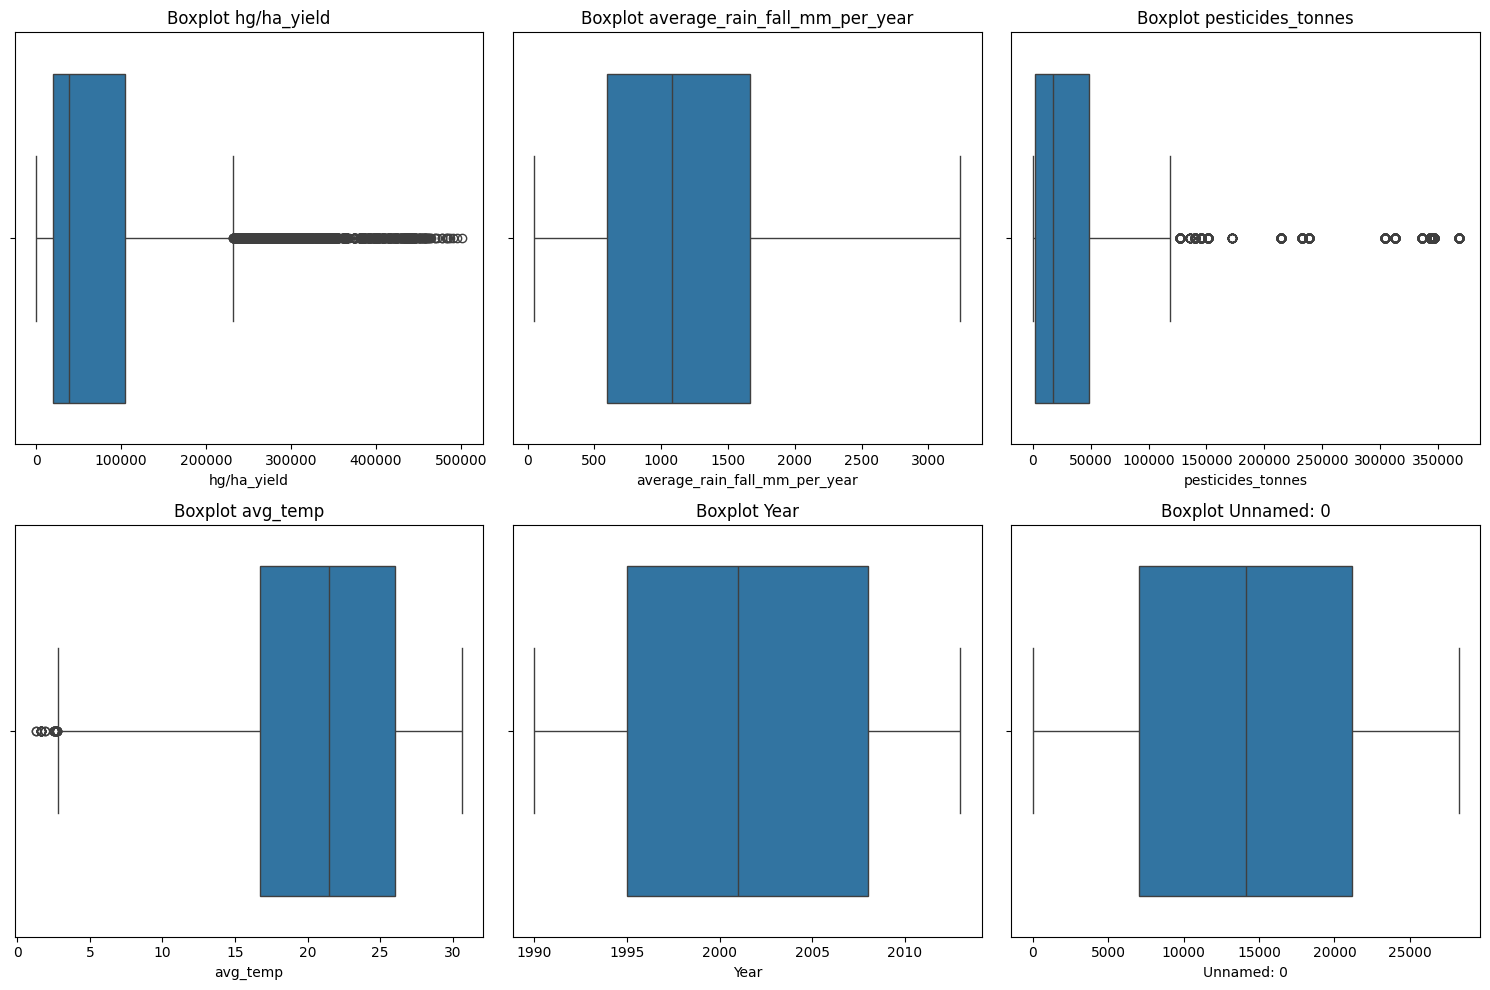

In [11]:
## Memeriksa Outlier

numerical_cols = ['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'Year', 'Unnamed: 0']

n_cols = 3
n_rows = (len(numerical_cols) + n_cols-1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
  sns.boxplot(x=df_crop[col], ax=axes[i])
  axes[i].set_title(f'Boxplot {col}')

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

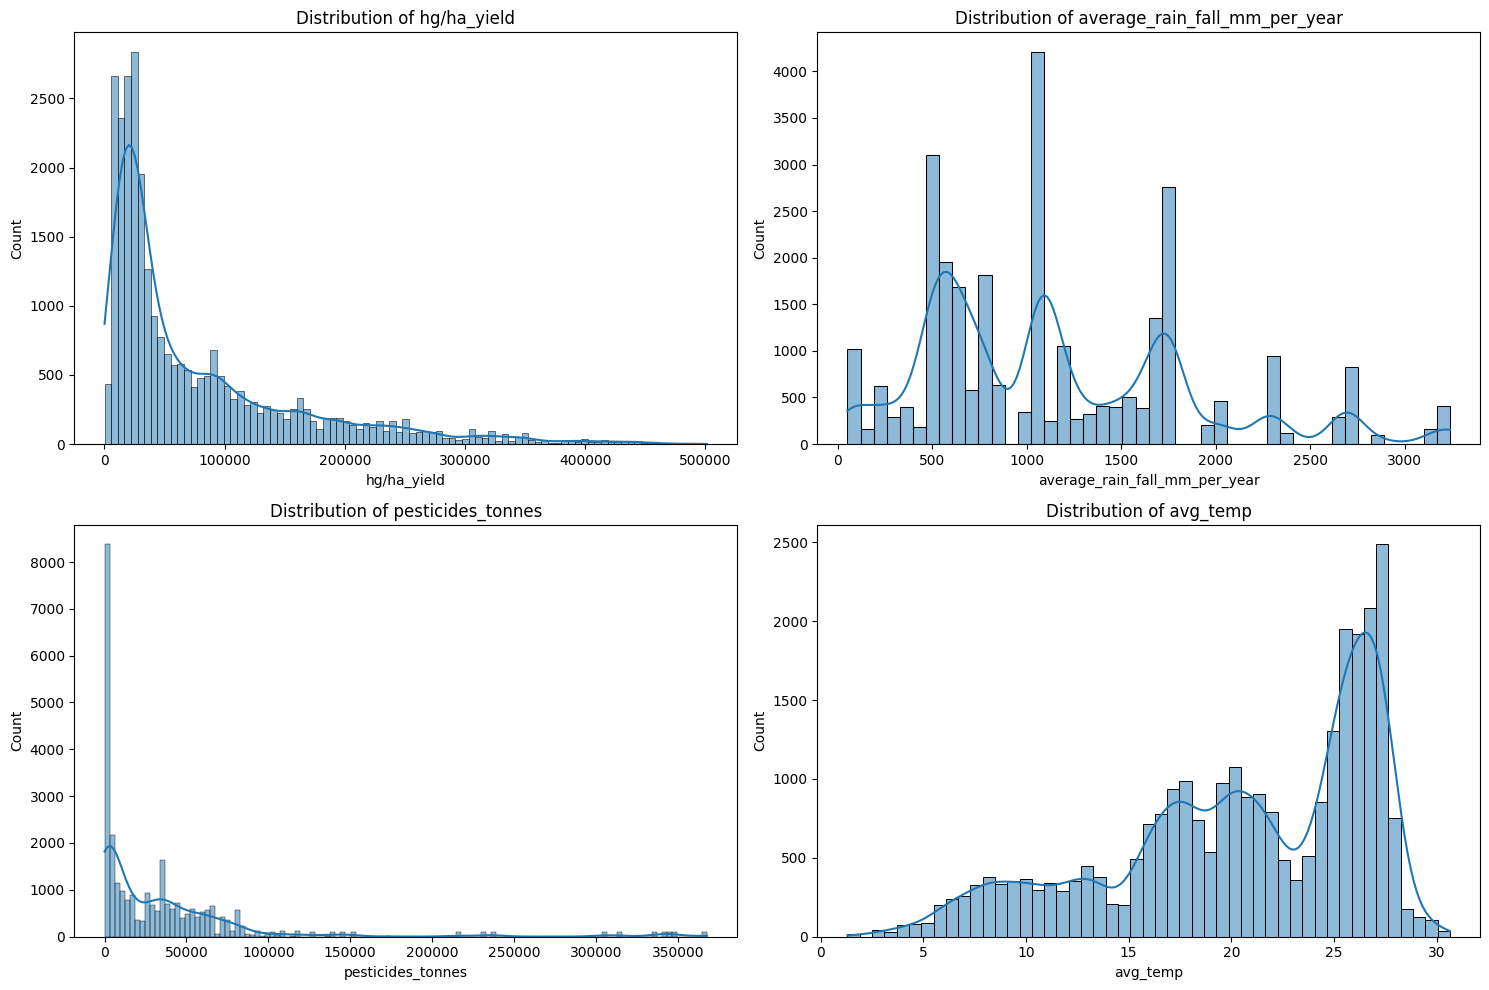

In [12]:
## Memeriksa Distribusi Data
cols = ['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

n_cols = 2
n_rows = (len(cols) + n_cols-1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
  sns.histplot(x=df_crop[col], ax=axes[i], kde=True)
  axes[i].set_title(f'Histogram {col}')
  axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Insight**

*   Fitur seperti hasil panen (hg/ha_yield) dan jumlah pestisida (pesticides_tonnes) memiliki rentang nilai yang jauh berbeda.
*   Ketika fitur memiliki skala yang sangat berbeda, model regresi multivariat bisa kesulitan untuk menemukan solusi optimal dengan cepat. Oleh karena itu, dibutuhkan normalisati data terutama untuk kedua fitur yang disebutkan sebelumnya
*   Tanpa normalisasi, fitur yang memiliki nilai lebih besar bisa mendominasi model, yang akhirnya membuat model kurang akurat. Dengan normalisasi, semua fitur akan berada dalam skala yang seragam, membantu model untuk memberikan prediksi yang lebih adil dan akurat.





# Data Preparation

In [13]:
# Menghapus kolom yang tidak diperlukan dalam model

df_crop = df_crop.drop(columns=['Unnamed: 0'], errors='ignore')
df_crop.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


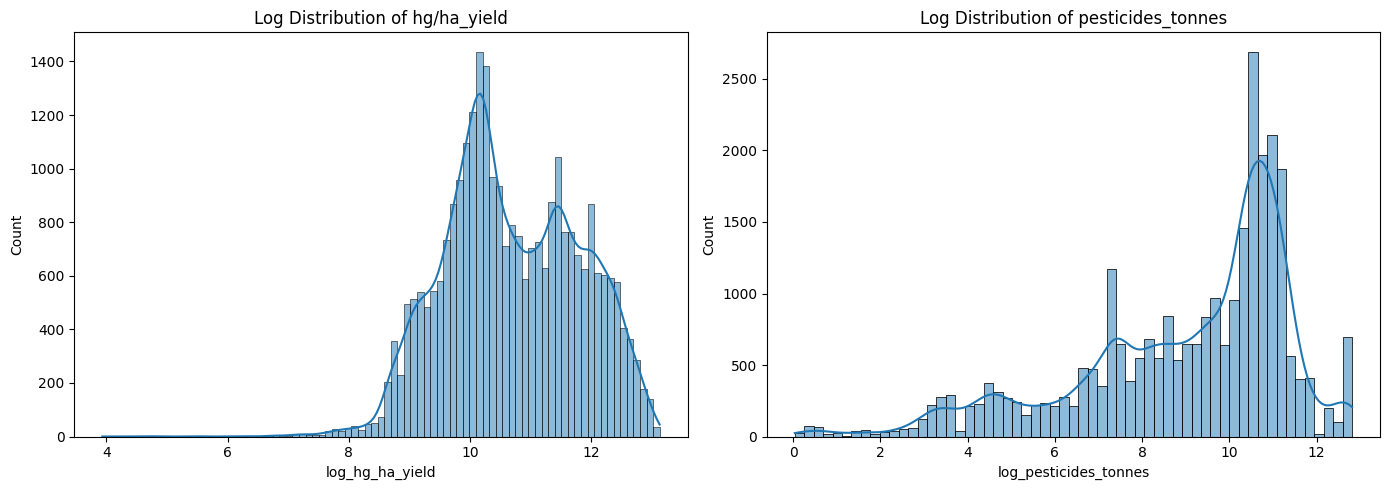

In [14]:
# Menangani permaslahan distribusi dan outlier dengan Transformasi Logaritmik

df_crop['log_hg_ha_yield'] = np.log1p(df_crop['hg/ha_yield'])
df_crop['log_pesticides_tonnes'] = np.log1p(df_crop['pesticides_tonnes'])

df_crop = df_crop.drop(columns=['hg/ha_yield', 'pesticides_tonnes'], errors='ignore')

#Grafik setelah transformasi logaritmik
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_crop['log_hg_ha_yield'], kde=True, ax=axes[0])
axes[0].set_title('Log Distribution of hg/ha_yield')

sns.histplot(df_crop['log_pesticides_tonnes'], kde=True, ax=axes[1])
axes[1].set_title('Log Distribution of pesticides_tonnes')

plt.tight_layout()
plt.show()

In [15]:
# Menggunakan Label Encoder untuk kolom kategorikal

label_encoder = LabelEncoder()

df_crop['Area'] = label_encoder.fit_transform(df_crop['Area'])
df_crop['Item'] = label_encoder.fit_transform(df_crop['Item'])

df_crop.head()

,Area,Item,Year,average_rain_fall_mm_per_year,avg_temp,log_hg_ha_yield,log_pesticides_tonnes
0,0,1,1990,1485.0,16.37,10.508186,4.804021
1,0,3,1990,1485.0,16.37,11.107480,4.804021
2,0,4,1990,1485.0,16.37,10.057667,4.804021
3,0,5,1990,1485.0,16.37,9.433564,4.804021
4,0,6,1990,1485.0,16.37,8.853808,4.804021


In [16]:
# Feature Scaling

scaler = StandardScaler()

numerical_cols = ['log_hg_ha_yield', 'log_pesticides_tonnes', 'average_rain_fall_mm_per_year', 'avg_temp']

df_crop[numerical_cols] = scaler.fit_transform(df_crop[numerical_cols])

df_crop[numerical_cols].describe()

,log_hg_ha_yield,log_pesticides_tonnes,average_rain_fall_mm_per_year,avg_temp
count,2.824200e+04,2.824200e+04,2.824200e+04,2.824200e+04
mean,-3.049280e-16,4.075771e-17,1.449163e-16,4.750034e-16
std,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00
min,-6.087601e+00,-3.611396e+00,-1.546994e+00,-3.048608e+00
25%,-7.064344e-01,-6.198117e-01,-7.833986e-01,-6.083909e-01
50%,-1.170621e-01,3.226406e-01,-9.306286e-02,1.532609e-01
75%,7.896547e-01,7.355536e-01,7.311134e-01,8.646112e-01
max,2.202239e+00,1.552894e+00,2.945823e+00,1.601310e+00


In [17]:
# Data Splitting
X = df_crop.drop(columns=['log_hg_ha_yield'])
y = df_crop['log_hg_ha_yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (22593, 6)
Shape of X_test: (5649, 6)
Shape of y_train: (22593,)
Shape of y_test: (5649,)


# Modeling

## linear Regeression

In [18]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Linear Regression Model Training Complete!")

Linear Regression Model Training Complete!


## Random Forest Regression

In [19]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest Model Training Complete!")

Random Forest Model Training Complete!


## XGBoost

In [20]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("XGBoost Model Training Complete!")

XGBoost Model Training Complete!


#Evaluation

In [22]:
#Mengukur Kinerja Semua Model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)


    print(f"Evaluation Metrics for {model_name}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared: {r2:.4f}")
    print("-" * 50)

    return mae, rmse, r2

# Evaluasi model Linear Regression
mae_lr, rmse_lr, r2_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")

# Evaluasi model Random Forest Regression
mae_rf, rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest Regression")

# Evaluasi model XGBoost Regression
mae_xgb, rmse_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost Regression")


results = {
    "Linear Regression": (mae_lr, rmse_lr, r2_lr),
    "Random Forest Regression": (mae_rf, rmse_rf, r2_rf),
    "XGBoost Regression": (mae_xgb, rmse_xgb, r2_xgb)
}

best_model = max(results, key=lambda x: results[x][2])
print(f"\nThe best model is: {best_model}")


Evaluation Metrics for Linear Regression:
Mean Absolute Error (MAE): 0.7965
Root Mean Squared Error (RMSE): 0.8891
R-squared: 0.1075
--------------------------------------------------
Evaluation Metrics for Random Forest Regression:
Mean Absolute Error (MAE): 0.0605
Root Mean Squared Error (RMSE): 0.0175
R-squared: 0.9825
--------------------------------------------------
Evaluation Metrics for XGBoost Regression:
Mean Absolute Error (MAE): 0.1164
Root Mean Squared Error (RMSE): 0.0318
R-squared: 0.9681
--------------------------------------------------

The best model is: Random Forest Regression
